In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution

Tic-Tac-Toe is a fairly easy to implement game. It's also fairly easy to play, which makes it a lot simpler to set up an AI capable of making plays(not necessarily good ones).

Here's the game itself:

In [2]:
class Tttgame:
    def __init__(self, size):
        self.size = size
        self.board = np.zeros((self.size, self.size))
        self.curPlayer = -1
        
    def isValidMove(self, coords):
        if self.board[coords] == 0:
            return True
        else:
            return False
        
    def play(self, coords):
        if self.isValidMove(coords):
            self.board[coords] = self.curPlayer
            self.curPlayer *= -1
            return 1
        return 0
    
    #This is ugly, I know
    #Returns the number corresponding to a player if he's the winner,
    #zero if there's no winner yet, or two if there's neither a winner
    #nor free slots to play in, ie. a tie(it can't tell in advance)
    def checkWinner(self):
        for i in self.board.sum(axis=0):
            if int(i/self.size) != 0:
                return int(i/self.size)
        for i in self.board.sum(axis=1):
            if int(i/self.size) != 0:
                return int(i/self.size)
        i = self.board.trace()
        if int(i/self.size) != 0:
            return int(i/self.size)
        i = self.board[::-1].trace()
        if int(i/self.size) != 0:
            return int(i/self.size)
        if self.board[self.board == 0].size == 0:
            return 2
        return 0
    
    #I'll prettify this, one day
    def printBoard(self):
        print(self.board)     

And an AI that simply chooses valid moves at random:

In [3]:
class RandomPlayer:
    def __init__(self, gameInstance):
        self.size = gameInstance.size
        self.instance = gameInstance
        
    def play(self):
        empty = np.where(self.instance.board == 0)
        randn = np.random.randint(0, empty[0].size)
        coords = tuple([empty[0][randn], empty[1][randn]])
        self.instance.play(coords)

And finally a single hidden layer neural network player:

In [83]:
class NNPlayer:
    def __init__(self, nneurons, gameInstance):
        self.instance = gameInstance
        self.ninputs = self.instance.size ** 2
        self.nneurons = nneurons
        self.hiddenLayerWeights = np.random.normal(size=(self.ninputs, self.nneurons))
        self.hiddenLayerBias = np.random.normal(size=(1, nneurons))
        self.outputLayerWeights = np.random.normal(size=(self.nneurons, 1))
        
    def attachNewGame(self, gameInstance):
        self.instance = gameInstance
        
    #This rather curious sigmoid is actually tailored for backprop(cf. Lecun, 1998)
    #will it work well in this differential evolution-backed problem? No idea.
    def sigmoid(self, x):
        return 1.7159 * np.tanh(2/3 * x)
    
    #I set this up rather haphazardly. A little more thought into the dimensions of
    #the matrices involved would probably result in cleaner code with less transposes
    def runNN(self, input):
        return np.dot(self.outputLayerWeights.T, 
                      self.sigmoid(np.dot(input.T, self.hiddenLayerWeights) + \
                                   self.hiddenLayerBias).T)[0,0]
    
    #Instead of using 2D coordinates as inputs/outputs I flatten the board into an
    #1D array both for simplicity and memory usage concerns.
    def evalBoard(self):
        ravelBoard = self.instance.board.flatten()
        emptyBoard = np.where(ravelBoard == 0)[0]
        scores = []
        for i in emptyBoard:
            ravelBoard[i] = 1
            scores.append(self.runNN(ravelBoard))
            ravelBoard[i] = 0
        scores = np.array(scores)
        max_idx = emptyBoard[np.where(scores == scores.max())[0][0]]
        res =  np.unravel_index(max_idx, self.instance.board.shape)
        return res
    
    #Who needs exceptions when you can BEEP! instead?
    def play(self):
        coords = self.evalBoard()
        res = self.instance.play(coords)
        if res == 0:
            print("BEEP!")
    
    #The cost function here is a weighed average of the results of many
    #games against a random player
    def cost(self):
        costInstance = Tttgame(self.instance.size)
        oldInstance = self.instance
        wincount = []
        N = 25
        
        for i in range(N):
            costInstance = Tttgame(self.instance.size)
            rp = RandomPlayer(costInstance)
            self.attachNewGame(costInstance)
            
            while True:
                rp.play()
                if(costInstance.checkWinner() != 0):
                    break
                self.play()
                if(costInstance.checkWinner() != 0):
                    break
            wincount.append(costInstance.checkWinner())
                
        self.attachNewGame(oldInstance)
        wincount = np.array(wincount)
        wincount[wincount == 2] = 0
        count = wincount.sum() / N
        return -count
    
    #Scipy's DE algorithm has very specific constraints on the form of
    #the function being minimized. This, absolutely atrocious, wrapper
    #bridges the gap between my implementation and what scipy wants
    def wrapperDE(self, weights):
        innerInstance = Tttgame(self.instance.size)
        trainGame = NNPlayer(self.nneurons, innerInstance)
        trainGame.importWeightVector(weights)
            
        return trainGame.cost()
    
    def importWeightVector(self, weights):
        cuts = np.cumsum([self.hiddenLayerWeights.size, \
                          self.hiddenLayerBias.size, \
                          self.outputLayerWeights.size])
        self.hiddenLayerWeights = weights[0:cuts[0]].reshape(self.hiddenLayerWeights.shape)
        self.hiddenLayerBias = weights[cuts[0]:cuts[1]].reshape(self.hiddenLayerBias.shape)
        self.outputLayerWeights = weights[cuts[1] :].reshape(self.outputLayerWeights.shape)
    
    def trainDE(self):
        bounds = np.array([(-1, 1)] * (self.hiddenLayerWeights.size + self.hiddenLayerBias.size + \
                         self.outputLayerWeights.size))
        trainResults = differential_evolution(self.wrapperDE, bounds, tol = 0.5)
        print(trainResults.message)
        
        if trainResults.success == True:
            self.importWeightVector(trainResults.x)
            print(trainResults.nit)
            print(trainResults.nfev)
            
        else:
            print("Optimization failed somewhere")
    

With everything set up let's see how the AI fares against a random player:

In [94]:
a = Tttgame(3)
nnp = NNPlayer(4, a)

In [95]:
N = 5000
wincount = []

for i in range(N):
    a = Tttgame(3)
    nnp.attachNewGame(a)
    rp = RandomPlayer(a)
    while True:
        rp.play()
        if(a.checkWinner() != 0):
            break
        nnp.play()
        if(a.checkWinner() != 0):
            break
    wincount.append(a.checkWinner())

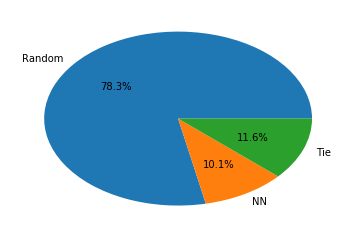

In [96]:
label, count = np.unique(wincount, return_counts=True)
label = ["Random", "NN", "Tie"]
count = count / N
plt.pie(count, labels=label, autopct='%.1f%%')
plt.show()

Not great, huh. Let's train it for a while and see if it does better.

In [97]:
nnp.trainDE()

Optimization terminated successfully.
17
13140


In [98]:
N = 5000
wincount = []

for i in range(N):
    a = Tttgame(3)
    nnp.attachNewGame(a)
    rp = RandomPlayer(a)
    while True:
        rp.play()
        if(a.checkWinner() != 0):
            break
        nnp.play()
        if(a.checkWinner() != 0):
            break
    wincount.append(a.checkWinner())

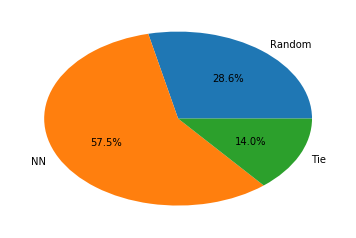

In [99]:
label, count = np.unique(wincount, return_counts=True)
label = ["Random", "NN", "Tie"]
count = count / N
plt.pie(count, labels=label, autopct='%.1f%%')
plt.show()

In [108]:
trained_vec = np.hstack((nnp.hiddenLayerWeights.ravel(), nnp.hiddenLayerBias.ravel(), nnp.outputLayerWeights.ravel()))

In [109]:
trained_vec.tofile("trainedvec.csv")